Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 253MB/s]


Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=196, bias=True)
Using 'cuda:0' to train the Model !
Epoch 1, duration: 92 s, loss: 5.0072, acc: 0.3932
Accuracy of the network on the test images: 15 %
Epoch 2, duration: 72 s, loss: 3.9773, acc: 1.6643
Accuracy of the network on the test images: 33 %
Epoch 3, duration: 70 s, loss: 3.3107, acc: 2.9681
Accuracy of the network on the test images: 43 %
Epoch 4, duration: 79 s, loss: 2.8203, acc: 4.2003
Accuracy of the network on the test images: 51 %
Epoch 5, duration: 98 s, loss: 2.5034, acc: 4.9618
Accuracy of the network on the test images: 58 %
Epoch 6, duration: 97 s, loss: 2.2554, acc: 5.7419
Accuracy of the network on the test images: 61 %
Epoch 7, duration: 68 s, loss: 1.7624, acc: 7.3191
Accuracy of the network on the test images: 74 %
Epoch 8, duration: 69 s, loss: 1.6294, acc: 7.8288
Accuracy of the network on the test images: 76 %
Epoch 9, duration: 69 s, loss: 1.5613, acc: 8.0728
Accura

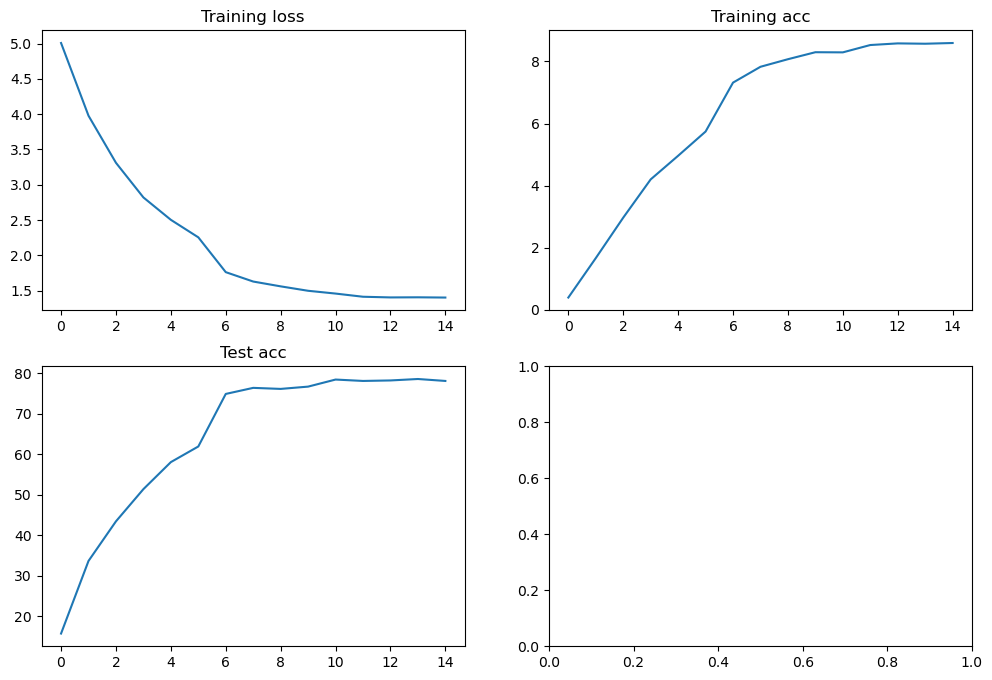

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms

import time

def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    return test_acc

if __name__ == '__main__':

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])

    train_dataset = datasets.ImageFolder(
        root='/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test',
        transform=train_transforms
    )
    val_dataset = datasets.ImageFolder(
        root='/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train',
        transform=val_transforms
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=2
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=2
    )

    model = models.resnet18(weights='IMAGENET1K_V1')
    print(model.fc)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 196)

    print(model.fc)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using '{device}' to train the Model !")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

    model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, lrscheduler, n_epochs=15)
    
    torch.save(model.state_dict(), "./trainedModelFinal.pt")
    
    f, axarr = plt.subplots(2,2, figsize = (12, 8))
    axarr[0, 0].plot(training_losses)
    axarr[0, 0].set_title("Training loss")
    axarr[0, 1].plot(training_accs)
    axarr[0, 1].set_title("Training acc")
    axarr[1, 0].plot(test_accs)

    axarr[1, 0].set_title("Test acc")
    
    model.eval()